In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import json, requests

# daily data used for US analysis
df_init = pd.read_csv('data/04-04-2020.csv')
df_density = pd.read_excel('data/density.xlsx')
df_male_female = pd.read_csv('data/Male vs female COVID cases - Country data.csv')

# time-series data used for US to other counties comparisons
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# map
state_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json').json()
county_geo = requests.get('https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us_counties_20m_topo.json').json()

# cleaning the data
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)

# grabbing only the US data
df_us = df_init.loc[df_init["Country_Region"]== "US"] 

# Renaming to more standard names
df_us = df_us.rename(columns={"Admin2":"County"})
df_us = df_us.rename(columns={"Confirmed":"Cases"})
df_us = df_us.rename(columns={'Province_State':'State'})

In [3]:
total = df_us.sum()
total.name = 'Total'

# calculating mortality rate
total["Mortality Rate"] = np.round(100*total["Deaths"]/total["Cases"],2)

# US Total Data table
pd.DataFrame(total).transpose().loc[:,["Cases","Deaths", 'Mortality Rate']]

,Cases,Deaths,Mortality Rate
Total,308850,8407,2.72


In [4]:
# US Top 10 states data table
df_us.loc[:,["Cases","Deaths","State"]].groupby(["State"]).sum().sort_values("Cases",ascending=False)[:10]

,Cases,Deaths
State,,
New York,113833,3565
New Jersey,34124,846
Michigan,14225,540
California,12837,289
Louisiana,12496,409
Massachusetts,11736,216
Florida,11545,195
Pennsylvania,10444,136
Illinois,10357,244


In [5]:
# US Top 10 Counties
df_us.loc[:,["State","Cases","Deaths","County"]].sort_values("Cases",ascending=False).set_index("County")[:10]

,State,Cases,Deaths
County,,,
New York City,New York,63306,1905
Nassau,New York,13346,95
Westchester,New York,13081,67
Suffolk,New York,11370,124
Cook,Illinois,7439,167
Wayne,Michigan,6762,252
Bergen,New Jersey,5760,179
Rockland,New York,4872,69
Los Angeles,California,4605,93


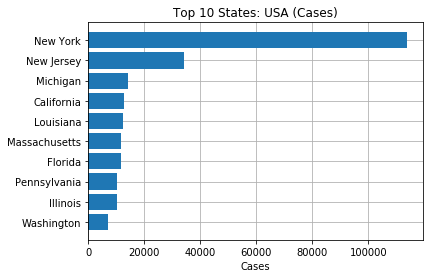

In [2]:
# Top 10 States USA Cases
f = plt.figure()

# 1x1 grid, first subplot
f.add_subplot(111)

# Remove lines through the bars
plt.axes(axisbelow=True)

# Plotting the cases
plt.barh(df_us.groupby(["State"]).sum().sort_values('Cases')["Cases"].index[-10:],df_us.groupby(["State"]).sum().sort_values('Cases')["Cases"].values[-10:])
plt.xlabel("Cases")
plt.title("Top 10 States: USA (Cases)")
plt.grid()
plt.savefig('figures/Top 10 States_USA (Cases).png')

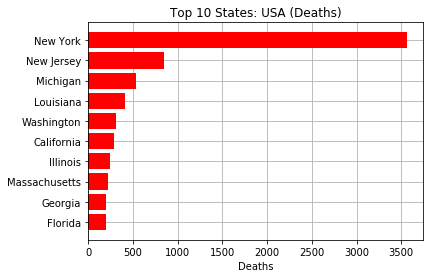

In [4]:
#Top 10 States Death cases
f = plt.figure()
f.add_subplot(111)

plt.axes(axisbelow=True)

#plotting the deaths
plt.barh(df_us.groupby(["State"]).sum().sort_values('Deaths')["Deaths"].index[-10:],df_us.groupby(["State"]).sum().sort_values('Deaths')["Deaths"].values[-10:],color="red")
plt.xlabel("Deaths")
plt.title("Top 10 States: USA (Deaths)")
plt.grid()
plt.savefig('figures/Top 10 States_USA (Deaths).png')

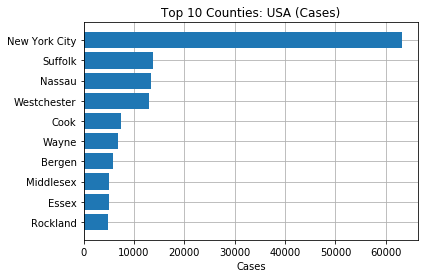

In [6]:
f = plt.figure()
f.add_subplot(111)

plt.axes(axisbelow=True)

#plotting Top 10 counties Cases
plt.barh(df_us.groupby(["County"]).sum().sort_values('Cases')["Cases"].index[-10:],df_us.groupby(["County"]).sum().sort_values('Cases')["Cases"].values[-10:])
plt.tick_params()
plt.xlabel("Cases")
plt.title("Top 10 Counties: USA (Cases)")
plt.grid()
plt.savefig('figures/Top 10 Counties_USA (Cases).png')

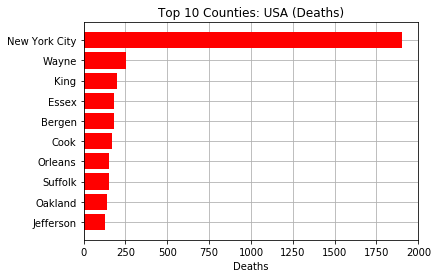

In [4]:
f = plt.figure()
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_us.groupby(["County"]).sum().sort_values('Deaths')["Deaths"].index[-10:],df_us.groupby(["County"]).sum().sort_values('Deaths')["Deaths"].values[-10:],color="red")
plt.xlabel("Deaths")
plt.title("Top 10 Counties: USA (Deaths)")
plt.grid()
plt.savefig('figures/Top 10 Counties_USA (Deaths).png')

In [6]:
# Grouping cases by state
data_temp = df_us.groupby(["State"]).sum().reset_index()

# log scale cases 
data_temp["Deaths_log"] = np.log10(data_temp["Deaths"] + 1)

# creating bins out of those values
bins = list(data_temp['Deaths_log'].quantile([0, 0.25, 0.5, 0.75, 0.95 , 1]))

# using Folium library in python to create a map https://python-visualization.github.io/folium/
m = folium.Map()

# Add the color for the chloropleth:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data = data_temp,
    columns=['State', 'Deaths_log'],
    key_on='feature.properties.name',
    fill_color='Reds',
    bins = bins,
    reset = True,
    legend_name = 'Deaths log (10^x)'
    ).add_to(m)
folium.LayerControl().add_to(m)

m

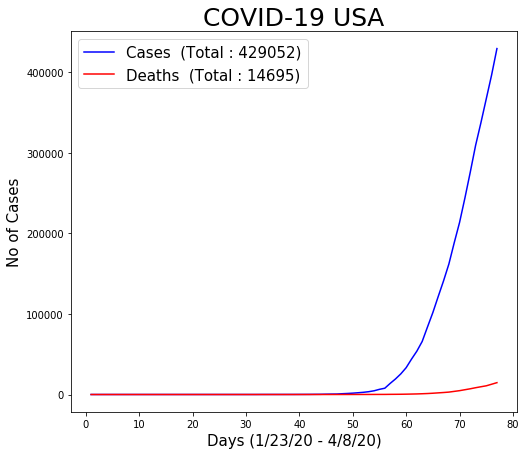

In [5]:
df_daily_us = df_confirmed.loc[df_confirmed["Country/Region"]== "US"]
df_daily_us_d = df_deaths.loc[df_deaths["Country/Region"]== "US"]

f = plt.figure(figsize=(8,7))

stats = [df_daily_us, df_daily_us_d]
label = ["Cases", "Deaths"]
color = ["blue","red"]

for i,stat in enumerate(stats):
    cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[0:]
    date = np.arange(1,cases.shape[0]+1)[0:]
    plt.plot(date, cases, label = f"{label[i]}  (Total : {str(cases[-1])})", color = color[i])
    Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]), axis = 0)[0:]
    Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]), axis = 0)[0:]

# Plot Parameters
xl = plt.xlabel(f"Days ({df_confirmed.columns[5]} - {df_confirmed.columns[-1]})", fontsize = 15)
yl = plt.ylabel("No of Cases", fontsize = 15)

# Plot Title
plt.title("COVID-19 USA", {'fontsize':25})

# Legend Location
l = plt.legend(loc= "best",fontsize = 15)
    
plt.savefig('figures/COVID-19 Cases USA.png')
plt.show()

In [43]:
# Hypothesis testing - One-tailed t-test
# H0: There is no difference between the probability of contracting COVID-19 if you are a male or a female: p_male = p_female
# H1: There is a higher chance of contracting COVID-19 if you are a male than if you are a female: p_male > p_female
import scipy.stats as stats
# male % cases in different countries
cases_males = [.51, .51, .46, .49, .50, .51, .51, .50, .55, .51, .47, .52, .56, .57, .55, .59, .51, .60, .44, .48, .41, .40, .49, .51, .48, .55, .49]
# female % cases in different countries
cases_females = [.49, .49, .54, .51, .50, .49, .49, .50, .45, .49, .53, .48, .44, .43, .45, .40, .49, .40, .56, .51, .55, .60, .51, .49, .52, .39, .51]
p = stats.ttest_ind(cases_males, cases_females)
print(p[1]/2)
# Is p smaller than the threshold of .05
p[1]/2 < .05
# We fail reject the null hypothesis (p-value >.05), therefore there is no statistical difference between men and women in terms of the probability of being infected by the virus

0.1013504542219751


False

In [42]:
# Hypothesis testing - One-tailed t-test
# H0: There is no difference between the probability of dying from COVID-19 if you are male or female: p_male = p_female
# H1: There is a higher chance of dying from COVID-19 if you are a male than female: p_male > p_females
import scipy.stats as stats
# male % deaths of cases in different countries
deaths_males = [.57, .64, .67, .58, .65, .59, .69, .58, .69, .53, .63, .59, .63, .61]
# female % deaths of cases in different countries
deaths_females = [.41, .36, .33, .42, .35, .41, .31, .42, .31, .47, .37, .41, .37, .39]
p = stats.ttest_ind(deaths_males, deaths_females)
print(p[1]/2)
p[1]/2 < .05
# We reject the null hypothesis (p-value <.05), therefore the probability of dying from COVID-19 is higher in men than in women

1.867440694801821e-13


True